In [2]:
## IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score


Tomamos los registros de los viajes de los Yellow Taxis en Nueva York de los meses del verano (julio, agosto y septiembre del año 2020), dado que el total de viajes del 2020 superaba los 24.000.000 de registros y no se podia trabajar con la libreria pandas.

In [3]:
# Ruta del archivo Parquet
file_path = 'dataset/dataset.parquet'

# Leer el archivo usando Pandas
df = pd.read_parquet(file_path)

Preguntas interesantes para considerar aquí: (elija una o dos)

• ¿Existe una manera de caracterizar los lugares más recurrentes para
inicio/fin de viaje? 

- Habría que reemplazar PULocationID y DOLocationID por su respectivo valor zonal, usando la columna "Zone" de 'dataset\taxi_zone_lookup.csv', y ver qué combinaciones son las mas frecuentes.
    

• ¿Cómo son los viajes típicamente en distancia y tiempo?

- Para la Distancia: usar trip_distance
- Para el Tiempo:Crear una nueva columna restanto tpep_dropoff_datetime y tpep_pickup_datetime, de aqui tenemos el tiempo total de viaje 

- IDEA: En que franja horaria ocurre la mayor cantidad de viajes?



• ¿Podremos segmentar los viajes de alguna manera? (clusterización)

- Ni idea, capaz por Mes y ver qué mes tiene mas viajes, cuales son más caros, etc.

## 2. Análisis exploratorio inicial

## - Visualizar las primeras filas.

In [4]:
#Checkeando que está todo bien
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2020-06-01 00:31:23,2020-06-01 00:49:58,1.0,3.6,1.0,N,140,68,1,15.5,3.0,0.5,4.00,0.0,0.3,23.30,2.5,NaN
1,1,2020-06-01 00:42:50,2020-06-01 01:04:33,1.0,5.6,1.0,N,79,226,1,19.5,3.0,0.5,2.00,0.0,0.3,25.30,2.5,NaN
2,1,2020-06-01 00:39:51,2020-06-01 00:49:09,1.0,2.3,1.0,N,238,116,2,10.0,0.5,0.5,0.00,0.0,0.3,11.30,0.0,NaN
3,1,2020-06-01 00:56:13,2020-06-01 01:11:38,1.0,5.3,1.0,N,141,116,2,17.5,3.0,0.5,0.00,0.0,0.3,21.30,2.5,NaN
4,1,2020-06-01 00:16:41,2020-06-01 00:29:30,1.0,4.4,1.0,N,186,75,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,NaN


In [5]:
df.shape

(2357495, 19)

## - Realizar un resumen de 5 números.

In [6]:
df.describe().loc[['min', '25%', '50%', '75%', 'max']]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
min,1.0,2008-12-31 23:05:27,2008-12-31 23:25:04,0.0,0.00,1.0,1.0,1.0,0.0,-480.00,-4.50,-0.5,-111.00,-28.75,-0.3,-480.80,-2.5,0.0
25%,1.0,2020-07-02 14:32:59.500000,2020-07-02 14:46:34,1.0,1.00,1.0,107.0,90.0,1.0,6.00,0.00,0.5,0.00,0.00,0.3,10.80,2.5,0.0
50%,2.0,2020-07-26 15:32:29,2020-07-26 15:47:57,1.0,1.80,1.0,161.0,160.0,1.0,9.00,0.50,0.5,1.66,0.00,0.3,14.15,2.5,0.0
75%,2.0,2020-08-14 13:42:17,2020-08-14 13:56:42.500000,1.0,3.40,1.0,234.0,233.0,2.0,15.00,2.50,0.5,2.75,0.00,0.3,20.49,2.5,0.0
max,6.0,2020-09-01 00:00:12,2020-09-01 21:40:56,9.0,256069.13,99.0,265.0,265.0,5.0,187438.96,90.06,3.3,1001.00,126.12,0.3,187443.26,2.5,0.0


## - Identificar los tipos de datos: categórico, ordinal, etc. Responder para cada variable su tipo y si es informativa para un problema de clasificación (por ejemplo si se trata de un código, como una matrícula, o un nombre propio).

In [7]:
# Identificar tipos de datos
data_types = df.dtypes

# Clasificación de tipos de datos
type_classification = {}
for column in df.columns:
    dtype = data_types[column]
    if pd.api.types.is_string_dtype(dtype):
        type_classification[column] = 'Categórico/Textual'
    elif pd.api.types.is_numeric_dtype(dtype):
        type_classification[column] = 'Numérico'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        type_classification[column] = 'Temporal'
    else:
        type_classification[column] = 'Otro'

# Evaluación de la informatividad para clasificación
informative_columns = {}
for column in df.columns:
    if type_classification[column] in ['Categórico/Textual', 'Numérico', 'Temporal']:
        # Heurística: los códigos únicos y nombres propios no son informativos
        if column.lower() in ['id', 'name', 'matricula', 'codigo','airport_fee','store_and_fwd_flag']:
            informative_columns[column] = 'No Informativa'
        else:
            informative_columns[column] = 'Informativa'
    else:
        informative_columns[column] = 'No Informativa'

# Crear un dataframe con la clasificación y evaluación
result_df = pd.DataFrame({
    'Tipo de Dato': [type_classification[col] for col in df.columns],
    'Informativa para Clasificación': [informative_columns[col] for col in df.columns]
}, index=df.columns)


# Mostrar el dataframe resultante
result_df

,Tipo de Dato,Informativa para Clasificación
VendorID,Numérico,Informativa
tpep_pickup_datetime,Temporal,Informativa
tpep_dropoff_datetime,Temporal,Informativa
passenger_count,Numérico,Informativa
trip_distance,Numérico,Informativa
RatecodeID,Numérico,Informativa
store_and_fwd_flag,Categórico/Textual,No Informativa
PULocationID,Numérico,Informativa
DOLocationID,Numérico,Informativa
payment_type,Numérico,Informativa


In [8]:
# Usando pandas profiling
report = ProfileReport(df, title='Yellow Taxis in NY', minimal=True)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Como podemos ver, casi todas las variables son informativas debido a la naturaleza intrinseca del dataset, ya que la descripcion de cada variable implica y explica una relacion directa con la variable de salida seleccionada. Más adelante veremos la relacion directa entre cada variable de entrada y la variable de salida.

- store_and_fwd_flag: No es informativa debido a que no aporta ningun tipo de criterio util segun la descripcion de la variable, ademas de tener muchos valores nulos.
- airport_fee: No es informativa debido a que solo hay un solo valor para esta variable en todo el dataset.

## - Identificar las variables de entrada y de salida del problema.

Todas menos total_amount son variables de entrada. 

- Variables de entrada:
  - Realizar los siguientes análisis por tipo de variable:
    - **Numéricas:** Obtener conclusiones acerca de la distribución de los datos.
    - **Categorías:** Obtener conclusiones acerca de la cardinalidad, representación de cada categoría, etc.
    - **Compuestas:** ¿Pueden tratarse para utilizarse en el problema a resolver?

In [1]:
df.hist(bins=10,
    figsize=(20, 15))
plt.suptitle('Histogramas de Variables de entrada')
plt.show()

NameError: name 'df' is not defined

## Variables de salida (en caso de aplicar): 
o ¿Están balanceadas las clases? 
o (en caso de aplicar) ¿Qué técnicas consideraría para codificar la variable de salida? 
Justifique.

count   2357495.00
mean         18.64
std         122.96
min        -480.80
25%          10.80
50%          14.15
75%          20.49
max      187443.26
Name: total_amount, dtype: float64


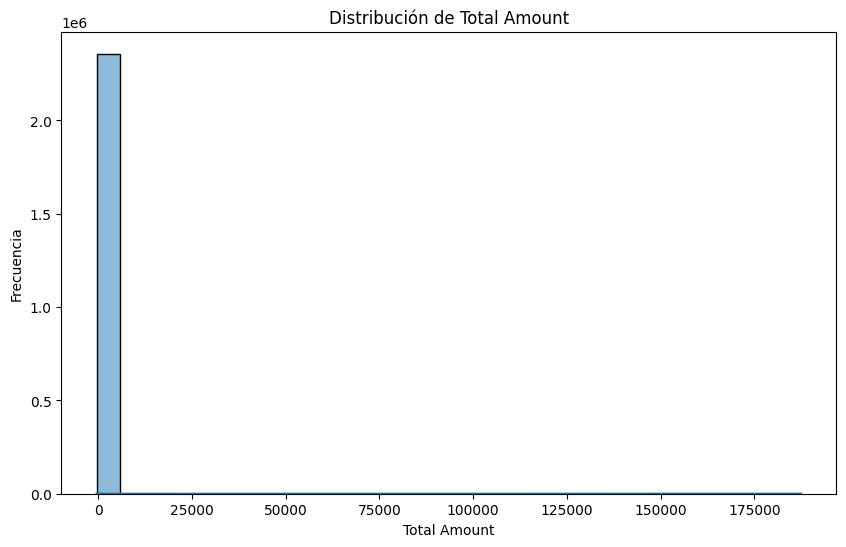

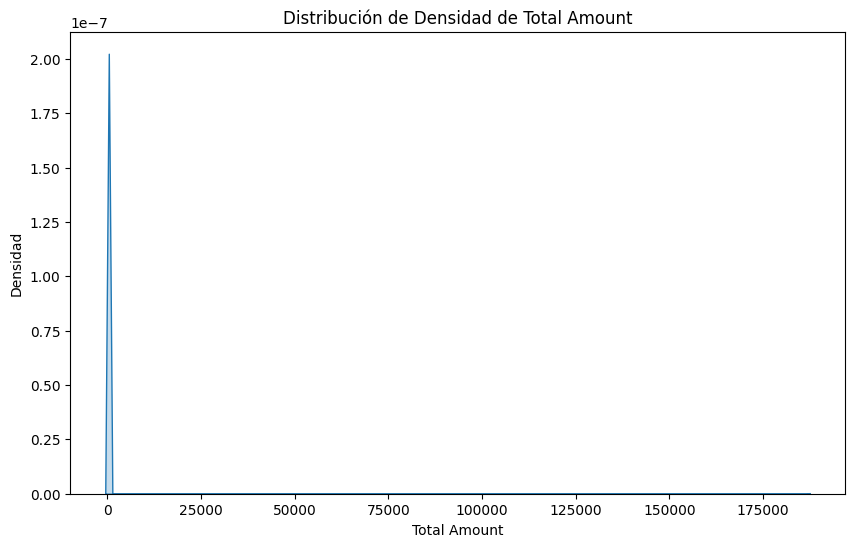

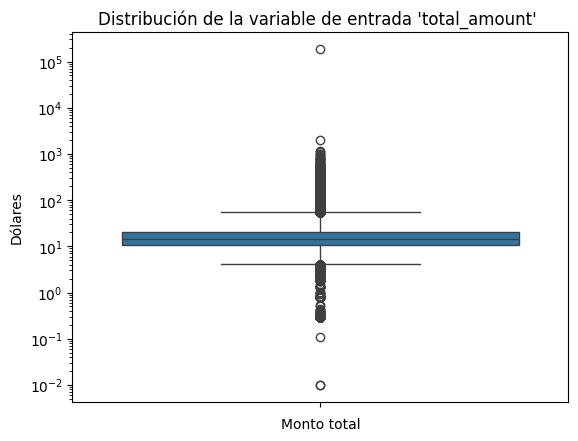

In [10]:
# Ajustar las opciones de visualización para mostrar los números en formato estándar
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Resumen estadístico
describe_stats = df['total_amount'].describe()
print(describe_stats)

# Visualizar la distribución con un histograma
plt.figure(figsize=(10, 6))
sns.histplot(df['total_amount'], bins=30, kde=True)
plt.title('Distribución de Total Amount')
plt.xlabel('Total Amount')
plt.ylabel('Frecuencia')
plt.show()

# Visualizar la distribución con un KDE plot (gráfico de densidad)
plt.figure(figsize=(10, 6))
sns.kdeplot(df['total_amount'], fill=True)
plt.title('Distribución de Densidad de Total Amount')
plt.xlabel('Total Amount')
plt.ylabel('Densidad')
plt.show()

# Visualizar la distribución con un boxplot
sns.boxplot(y="total_amount", data=df,log_scale=True)
plt.ylabel("Dólares")
plt.xlabel("Monto total")
plt.title("Distribución de la variable de entrada 'total_amount' ")
plt.show() 



## 3. Limpieza y preparación de datos / ingeniería de features




- Antes de entrenar un modelo de aprendizaje automático, ¿podría identificar las variables de entrada de mayor importancia? Considerar por lo menos dos técnicas para cada variable. Explique brevemente los métodos utilizados.

## - Datos faltantes. Indicar cantidad de observaciones y valores faltantes para cada variable.

In [11]:
df.isnull().sum()

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count           184804
trip_distance                  0
RatecodeID                184804
store_and_fwd_flag        184804
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge      184804
airport_fee              2357493
dtype: int64

## - ¿Qué supuestos puede realizar acerca de los datos faltantes? ¿Qué técnicas de imputación recomendaría? Ensayar distintas técnicas y analizar los resultados.

- 1. Eliminacion de columnas: Eliminaremos columnas completas que tienen un alto porcentaje de datos faltantes. 

En este caso, airport_fee tiene 2357493 datos faltantes.

In [12]:
#Eliminar columna
df.drop(columns=['airport_fee'], inplace=True)

#Validar nuevo dataset sin la columna 'airport_fee'              
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2357495 entries, 0 to 2357494
Data columns (total 18 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
dtypes: datetime64[us](2), 

- 2. Eliminacion de datos faltantes: Eliminaremos las observaciones que contengan valores nulos en 'passenger_count', 'RatecodeID', 'congestion_surcharge' y 'store_and_fwd_flag'. Esto porque los valores no aportan informacion relevante a nuestra variable de salida y representan un numero reducido de muestras en la cuenta total de observaciones.

In [13]:
#Eliminar valores nulos
df.dropna(inplace=True)
#Validar
df.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
dtype: int64

## - En función del estudio inicial de las variables que se hizo en la sección anterior, elegir una técnica de codificación para cada variable. Cuando lo considere apropiado, ensayar distintas técnicas y comparar los resultados, teniendo en cuenta el tipo de clasificador a utilizar. Nota: para tipos de datos compuestos o estructurados, considerar la obtención de variables de tipo numérico/categórico.

Debido a que todas las variables de entrada que vienen del dataset original vienen en formato numérico, no es muy beneficioso implementar tecnicas de codificacion ya que cualquier algoritmo que queramos utilizar va a funcionar e interpretar las variables de forma correcta siempre y cuando se manejen los outliers y valores nulos previamente, como ya hicimos.

Dicho esto, vamos a implementar Binary Encoding en unica variable categorica que tenemos para reemplazar los valores de Y y N en 'store_and_fwd_flag':

In [14]:
# Mostrar el DataFrame original
print("Variable original:")
print(df['store_and_fwd_flag'].head())

# Convertir 'Y' a 1 y 'N' a 0 usando map
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'Y': 1, 'N': 0})

# Mostrar el DataFrame convertido
print("Variable después de la conversión:")
print(df['store_and_fwd_flag'].head())

Variable original:
0    N
1    N
2    N
3    N
4    N
Name: store_and_fwd_flag, dtype: object
Variable después de la conversión:
0    0
1    0
2    0
3    0
4    0
Name: store_and_fwd_flag, dtype: int64


#### Chequeo de variables númericas:

> Primero vamos a ver si hay filas duplicadas y luego  vamos a chequear los limites de las columnas que tengan valores numéricos.  
Ninguna columna numérica debería tener valores negativos.

In [15]:
#Para ver filas duplicadas
df[df.duplicated(keep=False)]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
261289,1,2020-06-18 21:07:47,2020-06-18 21:07:47,0.00,0.00,99.00,1,264,264,1,13.30,0.00,0.00,0.00,0.00,0.00,13.30,0.00
261687,1,2020-06-18 21:07:47,2020-06-18 21:07:47,0.00,0.00,99.00,1,264,264,1,13.30,0.00,0.00,0.00,0.00,0.00,13.30,0.00


In [16]:
size_antes = len(df)
df = df.drop_duplicates()
size_despues = len(df)
print(f'se eliminaron: {size_antes-size_despues} filas duplicadas')

se eliminaron: 1 filas duplicadas


In [17]:
# se resetea
df.reset_index(drop=True, inplace=True)

In [18]:
columnas_con_numeros = ['VendorID', 'passenger_count' ,'trip_distance','RatecodeID','PULocationID','DOLocationID','payment_type','fare_amount','extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge',     'total_amount','congestion_surcharge']
(df[columnas_con_numeros] < 0).any().to_frame('Menor que 0 ?')

,Menor que 0 ?
VendorID,False
passenger_count,False
trip_distance,False
RatecodeID,False
PULocationID,False
DOLocationID,False
payment_type,False
fare_amount,True
extra,True
mta_tax,True


In [19]:
for c in columnas_con_numeros:
    print(c)
    display(df[df[c] < 0][c].value_counts().to_frame())
    print()

VendorID


,count
VendorID,



passenger_count


,count
passenger_count,



trip_distance


,count
trip_distance,



RatecodeID


,count
RatecodeID,



PULocationID


,count
PULocationID,



DOLocationID


,count
DOLocationID,



payment_type


,count
payment_type,



fare_amount


,count
fare_amount,
-2.50,1950
-3.00,747
-5.00,695
-4.50,680
-4.00,680
...,...
-391.50,1
-61.50,1
-53.10,1



extra


,count
extra,
-0.50,2611
-1.00,2031
-4.50,72
-2.50,4
-2.00,2
-3.00,1
-0.45,1
-0.80,1



mta_tax


,count
mta_tax,
-0.50,10876



tip_amount


,count
tip_amount,
-0.01,95
-0.66,35
-0.82,23
-0.99,7
-0.11,7
-1.44,5
-1.14,5
-0.76,4
-1.08,3



tolls_amount


,count
tolls_amount,
-6.12,164
-11.75,8
-2.80,6
-12.24,3
-2.29,2
-18.36,2
-28.75,1
-19.87,1
-8.41,1



improvement_surcharge


,count
improvement_surcharge,
-0.30,11061



total_amount


,count
total_amount,
-8.30,639
-7.80,624
-6.80,623
-5.80,610
-7.30,597
...,...
-7.45,1
-269.92,1
-55.42,1



congestion_surcharge


,count
congestion_surcharge,
-2.50,8534


## - ¿Qué puede decir acerca de las relaciones entre las variables de entrada?


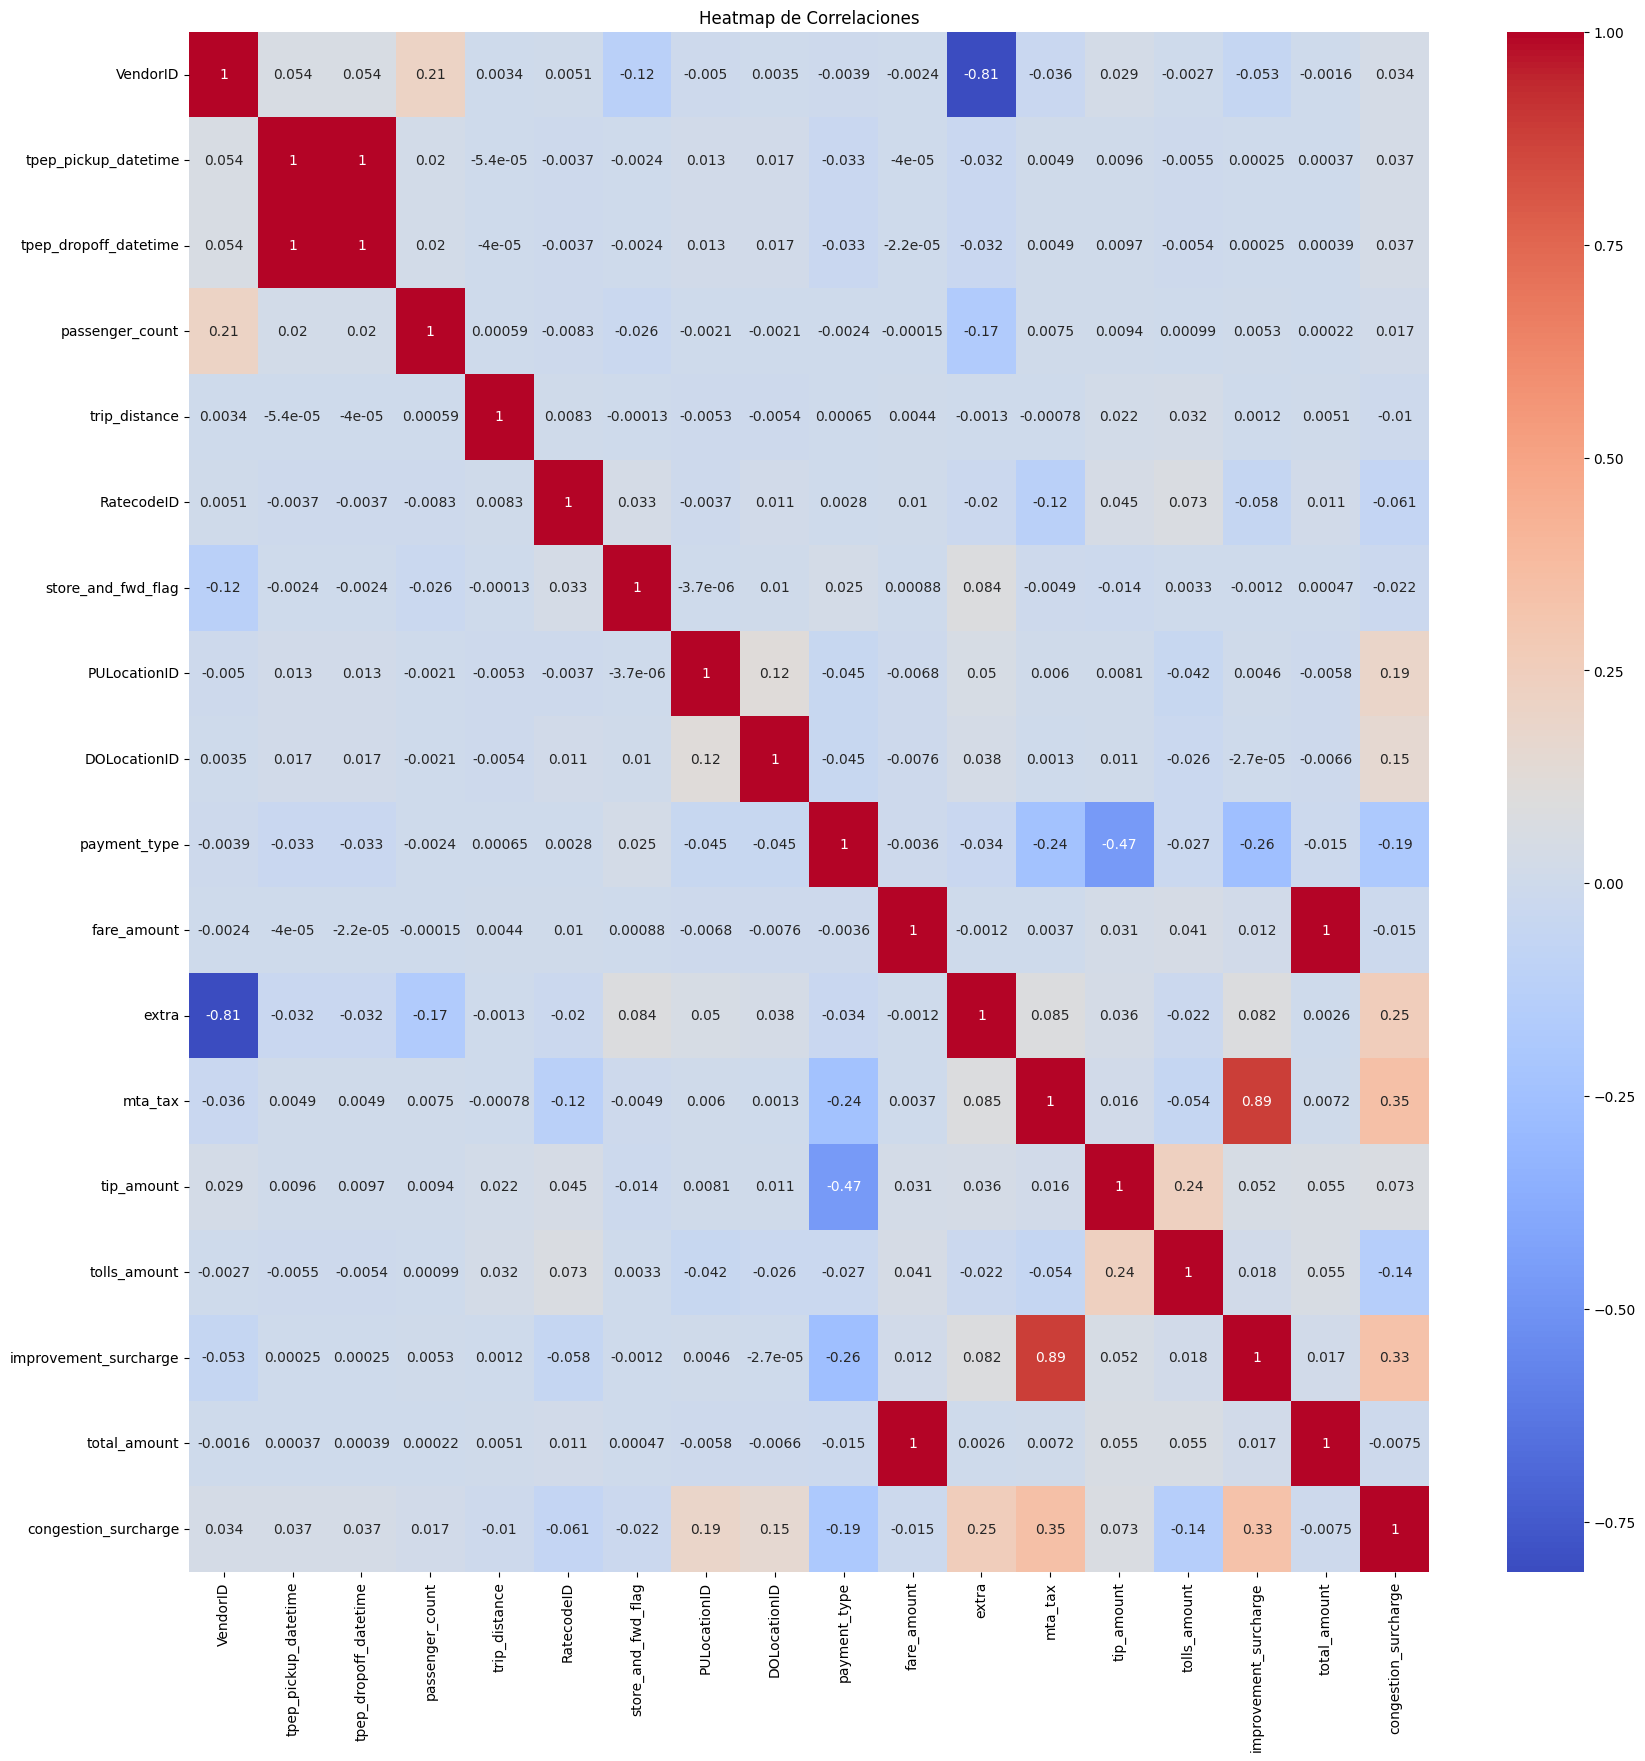

In [20]:
correlation_matrix = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

plt.title('Heatmap de Correlaciones')
plt.show()

In [21]:

# Detectar outliers usando el rango intercuartílico (IQR)
Q1 = df['total_amount'].quantile(0.25)
Q3 = df['total_amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['total_amount'] < lower_bound) | (df['total_amount'] > upper_bound)]
print(f'Número de outliers: {len(outliers)}')

Número de outliers: 191693


## Para elegir las variables de más importancia, vamos a  usar la técnica de filtrado de variables de forma estadística y técnicas embedded por árbol de decisión.

### Por varianza, se define un umbral mínimo para considerar variables. Por defecto elimina las features de varianza 0 (sin cambios) <br>
Para asegurarnos que funcione agreguemos variables con esas condiciones

In [23]:
_df = df.copy()
_df['with_zero_variance'] = 10
_df['with_low_variance'] = np.random.uniform(0, 0.2, _df.shape[0])

In [24]:
_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,with_zero_variance,with_low_variance
0,1,2020-06-01 00:31:23,2020-06-01 00:49:58,1.00,3.60,1.00,0,140,68,1,15.50,3.00,0.50,4.00,0.00,0.30,23.30,2.50,10,0.17
1,1,2020-06-01 00:42:50,2020-06-01 01:04:33,1.00,5.60,1.00,0,79,226,1,19.50,3.00,0.50,2.00,0.00,0.30,25.30,2.50,10,0.18
2,1,2020-06-01 00:39:51,2020-06-01 00:49:09,1.00,2.30,1.00,0,238,116,2,10.00,0.50,0.50,0.00,0.00,0.30,11.30,0.00,10,0.15
3,1,2020-06-01 00:56:13,2020-06-01 01:11:38,1.00,5.30,1.00,0,141,116,2,17.50,3.00,0.50,0.00,0.00,0.30,21.30,2.50,10,0.12
4,1,2020-06-01 00:16:41,2020-06-01 00:29:30,1.00,4.40,1.00,0,186,75,1,14.50,3.00,0.50,3.65,0.00,0.30,21.95,2.50,10,0.19


In [25]:
_df.select_dtypes(include=['number']).var()

VendorID                    0.23
passenger_count             1.08
trip_distance            3558.78
RatecodeID                  0.95
store_and_fwd_flag          0.01
PULocationID             4580.00
DOLocationID             5277.54
payment_type                0.27
fare_amount             16294.68
extra                       1.56
mta_tax                     0.01
tip_amount                  6.61
tolls_amount                1.68
improvement_surcharge       0.00
total_amount            16337.97
congestion_surcharge        0.80
with_zero_variance          0.00
with_low_variance           0.00
dtype: float64

In [26]:
def filter_by_variance(df, threshold):
    # Columnas con varianza calculable
    cols_con_varianza = df.var().index.values
    _df = df[cols_con_varianza].copy()
    print(f'columnas antes: {_df.columns.tolist()}')

    # calculo varianzas
    selector = VarianceThreshold(threshold=threshold)
    vt = selector.fit(_df)

    ## vt.get_support() me da los indices de las columnas que quedaron
    _df = _df.loc[:, vt.get_support()]
    print(f'columnas que quedan: {_df.columns.tolist()}')


filter_by_variance(_df.select_dtypes(include=['number']), 0)
print()
filter_by_variance(_df.select_dtypes(include=['number']), 10)

columnas antes: ['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'with_zero_variance', 'with_low_variance']
columnas que quedan: ['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'with_low_variance']

columnas antes: ['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'with_zero_variance', 'with_low_variance']
columnas que quedan: ['trip_distance', 'PULocation

### Recursive Feature Eliminator a través de Arboles de Decisión con Regresión Lineal porque las variables son continuas.
 



In [27]:

columnas_con_numeros = ['VendorID', 'passenger_count' ,'trip_distance','RatecodeID','PULocationID','DOLocationID','payment_type','fare_amount','extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge',     'total_amount','congestion_surcharge']


# Definir X e y. Supongamos que la etiqueta está en una columna llamada 'total_amount'
X = df[columnas_con_numeros].drop(columns=['total_amount'])  # Elimina la columna de la etiqueta de X
y = df[columnas_con_numeros]['total_amount']  # La columna de la etiqueta

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [28]:
# Entrenar el modelo Decision Tree (como las variables son continuas usando regresión)



# Entrenar el modelo Decision Tree Regressor
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)



DecisionTreeRegressor(random_state=42)

In [29]:
#Predecir 

y_pred = model.predict(X_test)


In [30]:

#Calcular métricas de evaluación para regresión



      
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')


    

Mean Squared Error: 0.51
R^2 Score: 1.00


In [31]:


# Obtener la importancia de las características
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Mostrar la importancia de las características
print("Importancia de las características:")
print(feature_importance_df)


Importancia de las características:
                  Feature  Importance
0                VendorID        0.00
1         passenger_count        0.00
2           trip_distance        0.00
3              RatecodeID        0.00
4            PULocationID        0.00
5            DOLocationID        0.00
6            payment_type        0.00
7             fare_amount        1.00
8                   extra        0.00
9                 mta_tax        0.00
10             tip_amount        0.00
11           tolls_amount        0.00
12  improvement_surcharge        0.00
13   congestion_surcharge        0.00
